In [1]:
import numpy as np 
from scipy.stats import multivariate_normal
import Estimateurs
import matplotlib.pyplot as plt

On commence par tirer le $\theta$* ($\in \mathbb{R}$) qui sera le paramètre que l'on cherchera à estimer par la suite. 

A la manière de la génération des données dans l'article Rainforth et al. (2018) : $\theta^* \sim \mathcal{N}(0, 1)$

In [2]:
#theta_true = np.random.multivariate_normal(np.zeros(20), np.identity(20))
theta_true = np.random.normal(0, 1)
print(f"La valeur de theta à estimer est {int(theta_true*100)/100}")

La valeur de theta à estimer est -0.66


Désormais, on va tirer un échantillon $((Z_i, X_i))_i \stackrel{iid}{\sim} \mathcal{N}(\boldsymbol{z}|\theta, \boldsymbol{I}) * \mathcal{N}(\boldsymbol{x}|\boldsymbol{z}, \boldsymbol{I})$. 


In [3]:
## On se donne notre échantillon x

x, _ = Estimateurs.joint_probability(theta_true)

print(f"L'échantillon x observé est :\n \n x = {x} \n \n et sa taille est {x.shape}")

L'échantillon x observé est :
 
 x = [-0.4770218  -0.96603065 -0.33877587 -0.0877593  -0.41807327 -2.26712098
 -1.91314777 -1.74194017  0.09930895 -0.91322796 -0.12175917 -1.19424374
 -1.23298221 -0.92362406  0.56894047  0.23389573  2.21334205  0.59054709
  1.16979136 -2.34467645] 
 
 et sa taille est (20,)


Ceci nous suffit pour tester notre classe Estimateurs dont le code se trouve dans le fichier Estimateurs.py

In [4]:
estimateur = Estimateurs.Estimateurs(x, theta_true, 0.6)

In [5]:
x = estimateur.grad_ML_RR(theta_star=theta_true, n_simulations=1)

Step: 0.0%
Step: 3.3%
Step: 6.7%
Step: 10.0%
Step: 13.3%
Step: 16.7%
Step: 20.0%
Step: 23.3%
Step: 26.7%
Step: 30.0%
Step: 33.3%
Step: 36.7%
Step: 40.0%
Step: 43.3%
Step: 46.7%
Step: 50.0%
Step: 53.3%
Step: 56.7%
Step: 60.0%
Step: 63.3%
Step: 66.7%
Step: 70.0%
Step: 73.3%
Step: 76.7%
Step: 80.0%
Step: 83.3%
Step: 86.7%
Step: 90.0%
Step: 93.3%
Step: 96.7%


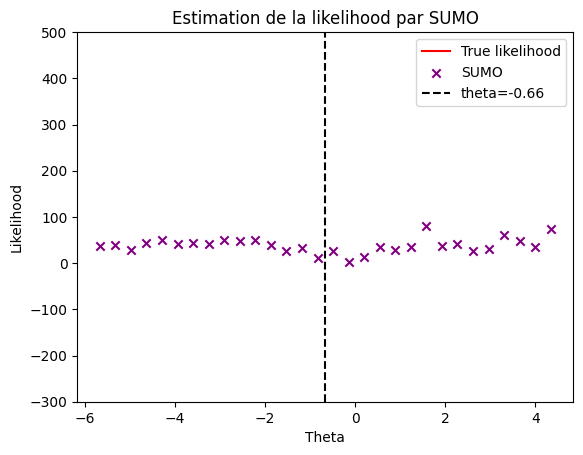

In [7]:
estimateur.plot_likelihood(theta_true, 1, 'SUMO')